In [206]:
import folium
import pandas as pd
import geopandas as gpd

In [227]:
villuco = pd.read_csv('villuco_random_points.csv',usecols=[1,3], header=None, names=['La', 'Lo'])

In [228]:
villuco.shape

(12000, 2)

In [209]:
villuco.head()

,La,Lo
0,-36.883353,-73.028225
1,-36.876237,-73.039206
2,-36.881862,-73.032576
3,-36.873547,-73.036828
4,-36.868998,-73.036127


In [232]:
villuco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
La    12000 non-null float64
Lo    12000 non-null float64
dtypes: float64(2)
memory usage: 187.6 KB


In [305]:
lat = villuco['La'].tolist()
long = villuco['Lo'].tolist()
coords = zip(lat,long)

In [231]:
# import folium
# import folium.plugins

# COORDINATES = [-36.8774383, -73.03479]

# m = folium.Map(location=COORDINATES, zoom_start=20)
# marker_cluster = folium.plugins.MarkerCluster().add_to(m)

# # folium.Marker([45.3288, -121.6625], popup='<i>Mt. Hood Meadows</i>').add_to(m)

# lat = villuco['La'].tolist()
# long = villuco['Lo'].tolist()
# coords = zip(lat,long)

# for coord in zip(lat,long):
#     folium.Marker([coord[0], coord[1]]).add_to(marker_cluster)
# m

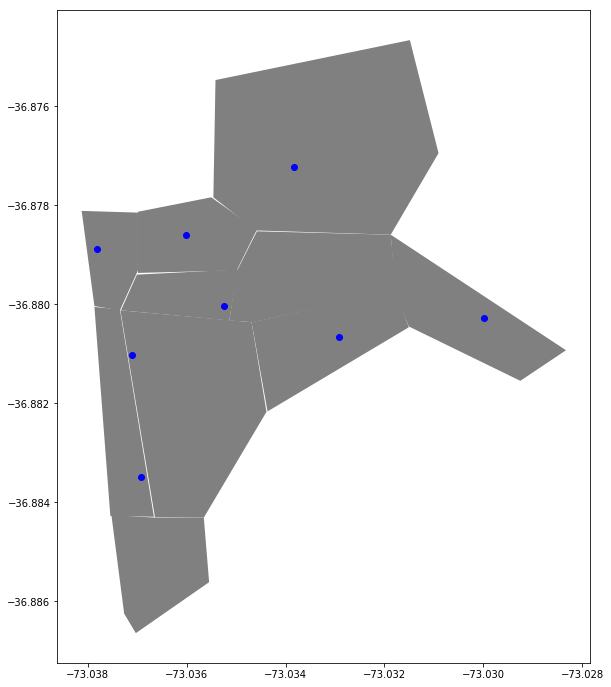

In [307]:
from shapely.geometry import Point, Polygon
import geopandas

polys = geopandas.read_file('villuco.geojson')
puntos2 = geopandas.read_file('villuco_points.geojson')
polys.reset_index(inplace=True)
# polys = polys.geometry

points = []
for coord in zip(lat,long):
    points.append(Point(coord[1], coord[0]))

pnts = geopandas.GeoDataFrame(geometry=points)

f, ax = plt.subplots(figsize=(15,12))
polys.plot(ax=ax, color='gray')
puntos2.plot(ax=ax, color='blue')

plt.show()


In [308]:
import random
import time

def strTimeProp(start, end, format, prop):
    """Get a time at a proportion of a range of two formatted times.

    start and end should be strings specifying times formated in the
    given format (strftime-style), giving an interval [start, end].
    prop specifies how a proportion of the interval to be taken after
    start.  The returned time will be in the specified format.
    """

    stime = time.mktime(time.strptime(start, format))
    etime = time.mktime(time.strptime(end, format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(format, time.localtime(ptime))


def randomDate(start, end, prop):
    return strTimeProp(start, end, '%m/%d/%Y %I:%M %p', prop)

rnd_date = randomDate("1/1/2016 1:00 AM", "1/10/2018 11:59 PM", random.random())
print(rnd_date)
pd.to_datetime(rnd_date)

06/02/2017 04:44 AM


Timestamp('2017-06-02 04:44:00')

In [335]:
zone = []
timestamp = []
reason_choice = ['asalto', 'auto sospechoso', 'persona sospechosa', 'violencia callejera', 'disturbio', 'prueba sistema']
reason = []
resulting_points = []

# print(random.choice(reason_choice))
for i in range(polys.shape[0]):
    mask = pnts.within(polys.loc[i,'geometry'])
    s = pnts[mask]
    s_length = s.shape[0]
    resulting_points.extend(s.geometry.tolist())
    zone.extend(['{}'.format(i)]*s_length)
    r,t  = [], []
    for j in range(s_length):
        t.append(randomDate("1/1/2016 1:00 AM", "1/10/2018 11:59 PM", random.random()))
        r.append(random.choice(reason_choice))
    reason.extend(r)
    timestamp.extend(t)

print(len(zone))
print(len(reason))
print(len(resulting_points))
print(len(timestamp))

1824
1824
1824
1824


In [341]:
crimedata = pd.DataFrame({'razon':reason, 'zona':zone, 'geometry':resulting_points, 'timestamp':timestamp})
crimedata.to_csv('ConcepcionDelincuenciaApp/villuco_simulado.csv')

In [337]:
# state_geo = os.path.join('data', 'us-states.json')
SF_COORDINATES = (37.76, -122.45)

m2 = folium.Map(location=COORDINATES, zoom_start=16)
district_geo = r'villuco.geojson'

crimedata['1'] = 1
crimedata2 = crimedata.groupby('zona').sum()
# crimedata2

district_geo.index

crimedata2.reset_index(inplace=True)

cd = crimedata2[['Police District', '1']]
cd.columns = ['district', '1']
cd.district = cd.district.str.upper()

m2.choropleth(
    geo_data=district_geo,
    name='choropleth',
    data=cd,
    columns=['district', '1'],
    key_on='feature.properties.district',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of incidents per district'
)

marker_cluster = folium.plugins.MarkerCluster().add_to(m2)

# folium.Marker([45.3288, -121.6625], popup='<i>Mt. Hood Meadows</i>').add_to(m)

lat = villuco['La'].tolist()
long = villuco['Lo'].tolist()
coords = zip(lat,long)

for coord in zip(lat,long):
    folium.Marker([coord[0], coord[1]]).add_to(marker_cluster)

folium.LayerControl().add_to(m2)

m2

C:\Users\joaquin\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


KeyboardInterrupt: 

In [393]:
crimedata['geometry'].loc[0].x

-73.03805973

In [411]:
import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1Ijoicm11aXIiLCJhIjoiY2o1MjBxcnkwMDdnZTJ3bHl5bXdxNW9uaCJ9.QR6f0fRLkHzmCgL70u5Hzw'

# [-36.8774383, -73.03479]

data = [go.Scattermapbox(
            lat=[ x.y for x in crimedata['geometry'].tolist()],
            lon=[ x.x for x in crimedata['geometry'].tolist()],
            mode='markers',
            marker=dict(
                size=7,
                color = 'red'
            ),
            text=crimedata['razon'],
    hoverinfo = 'text'
        )]
layout = {
        'height' : 600,
        'paper_bgcolor' : 'rgb(26,25,25)',
              'font' : {
                  'color' : 'rgb(250,250,250)'
              }, # Set this to match the colour of the sea in the mapbox colourscheme
        'autosize' : True,
        'hovermode' : 'closest',
        'mapbox' : {
            'accesstoken' : mapbox_access_token,
            'center' : {  # Set the geographic centre - trial and error
                'lat' : -36.880592,
                'lon' : -73.036790
            },
            'zoom' : 14.5,
            'style' : 'dark',   # Dark theme will make the colours stand out
        },
        'margin' : {'t' : 0,
                   'b' : 0,
                   'l' : 0,
                   'r' : 0},
        'legend' : {
            'font' : {'color' : 'white'},
             'orientation' : 'h',
             'x' : 0,
             'y' : 2,
        }
    }
fig = dict(data=data, layout=layout)

py.iplot(fig, filename='Montreal Mapbox')

In [345]:
# Read in data from csv stored on github
#csvLoc = 'accidents2015_V.csv'  
csvLoc = 'https://raw.githubusercontent.com/richard-muir/uk-car-accidents/master/accidents2015_V.csv'
acc = pd.read_csv(csvLoc, index_col = 0).dropna(how='any', axis = 0)
# Remove observations where speed limit is 0 or 10. There's only three and it adds a lot of 
#  complexity to the bar chart for no material benefit
acc = acc[~acc['Speed_limit'].isin([0, 10])]
# Create an hour column
acc['Hour'] = acc['Time'].apply(lambda x: int(x[:2]))

In [401]:
def get_map(severity, weekdays, time):
    hours = [i for i in range(time[0], time[1]+1)]
#     Filter the dataframe
    acc2 = acc[
            (acc['Accident_Severity'].isin(severity)) &
            (acc['Day_of_Week'].isin(weekdays)) & 
            (acc['Hour'].isin(hours))
            ]

    # Once trace for each severity value
    traces = []
    for sev in sorted(severity, reverse=True):
        # Set the downsample fraction depending on the severity
        sample = 1
        if sev == 'Slight':
            sample = SLIGHT_FRAC
        elif sev == 'Serious':
            sample = SERIOUS_FRAC
        # Downsample the dataframe and filter to the current value of severity
        acc3 = acc2[acc2['Accident_Severity'] == sev].sample(frac=sample)
            
        # Scattermapbox trace for each severity
        traces.append({
            'type' : 'scattermapbox',
            'mode' : 'markers',
            'lat' : acc3['Latitude'],
            'lon' : acc3['Longitude'],
            'marker' : {
                'color' : SEVERITY_LOOKUP[sev], # Keep the colour consistent
                'size' : 2,
            },
            'hoverinfo' : 'text',
            'name' : sev,
            'legendgroup' : sev,
            'showlegend' : False,
            'text' : acc3['Local_Authority_(District)'] # Text will show location
        })
        
        # Append a separate marker trace to show bigger markers for the legend. 
        #  The ones we're plotting on the map are too small to be of use in the legend.
        traces.append({
            'type' : 'scattermapbox',
            'mode' : 'markers',
            'lat' : [0],
            'lon' : [0],
            'marker' : {
                'color' : SEVERITY_LOOKUP[sev],
                'size' : 10,
            },
            'name' : sev,
            'legendgroup' : sev,
            
        })
    layout = {
        'height' : 300,
        'paper_bgcolor' : 'rgb(26,25,25)',
              'font' : {
                  'color' : 'rgb(250,250,250)'
              }, # Set this to match the colour of the sea in the mapbox colourscheme
        'autosize' : True,
        'hovermode' : 'closest',
        'mapbox' : {
            'accesstoken' : mapbox_access_token,
            'center' : {  # Set the geographic centre - trial and error
                'lat' : 54.5,
                'lon' : -2
            },
            'zoom' : 3.5,
            'style' : 'dark',   # Dark theme will make the colours stand out
        },
        'margin' : {'t' : 0,
                   'b' : 0,
                   'l' : 0,
                   'r' : 0},
        'legend' : {
            'font' : {'color' : 'white'},
             'orientation' : 'h',
             'x' : 0,
             'y' : 1.01
        }
    }
    fig = dict(data=traces, layout=layout) 
    return fig

In [404]:
import plotly.plotly as py
import plotly.graph_objs as go
# Make the colours consistent for each type of accident
severity = ['asalto', 'auto sospechoso', 'persona sospechosa', 'violencia callejera', 'disturbio', 'prueba sistema']

SEVERITY_LOOKUP = {'asalto' : 'red',
                    'auto sospechoso' : 'orange',
                    'persona sospechosa' : 'yellow',
                    'violencia callejera' : 'brown',
                    'disturbio' : 'gray',
                   'prueba sistema' : 'blue'
                  }

SEVERITY_LOOKUP = {'Fatal' : 'red',
                    'Serious' : 'orange',
                    'Slight' : 'yellow'}

# Need to downsample the number of Slight and Serious accidents to display them 
# on the map. These fractions reduce the number plotted to about 10k.
# There are only about 10k fatal accidents so don't need to downsample these
SLIGHT_FRAC = 0.1
SERIOUS_FRAC = 0.5

# This dict allows me to sort the weekdays in the right order
DAYSORT = dict(zip(['Friday', 'Monday', 'Saturday','Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
                  [4, 0, 5, 6, 3, 1, 2]))


mapbox_access_token = 'pk.eyJ1Ijoicm11aXIiLCJhIjoiY2o1MjBxcnkwMDdnZTJ3bHl5bXdxNW9uaCJ9.QR6f0fRLkHzmCgL70u5Hzw'


fig = get_map(['Slight', 'Serious', 'Fatal'], 
              ['Monday', 'Tuesday', 'Thursday', 'Sunday', 'Friday', 'Wednesday', 'Saturday'], 
              [0, 23])

py.iplot(fig)